<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/ResNet50%20final/Tanpa%20TL%20Image%20Net%20100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Preprocessing
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

#Model dan Augmentasi
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from keras.applications import ResNet50

# Evaluasi
#import torch
#import torchvision.models as models
#from thop import profile
from sklearn.metrics import confusion_matrix, classification_report

#Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smjayyy","key":"07729aa6a210c0f9baaeed1cf96a6a3b"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
##link dataset in Kaggle.com
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 99% 159M/161M [00:02<00:00, 78.7MB/s]
100% 161M/161M [00:02<00:00, 57.2MB/s]


In [5]:
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

In [6]:
dataset_dir = '/content/data'

In [7]:
print(os.listdir(dataset_dir))

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [8]:
IMAGE_SIZE_resnet50 = 224

In [9]:
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_SIZE_resnet50, IMAGE_SIZE_resnet50))
        img_list.append(np.array(img))
        label_list.append(str(label))

In [10]:
X = []
Z = []

In [11]:
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(class_name, class_dir, X, Z)

100%|██████████| 1146/1146 [00:04<00:00, 243.94it/s]


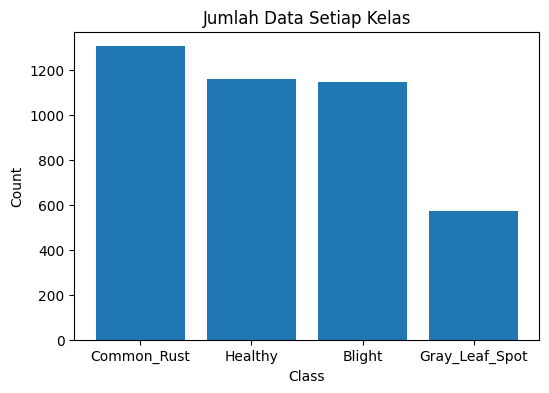

In [12]:
# Menghitung jumlah data untuk setiap kelas
class_counts = {class_name: Z.count(class_name) for class_name in set(Z)}

# Menampilkan visualisasi jumlah data
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Jumlah Data Setiap Kelas')
plt.show()

In [13]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=len(le.classes_))

# Konversi ke array numpy
X = np.array(X)

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Jumlah Data Train adalah :", len(X_train))
print("Jumlah Data Test adalah :", len(X_test))

Jumlah Data Train adalah : 3350
Jumlah Data Test adalah : 838


In [19]:
print(X_train[0])

[[[195 222 206]
  [191 218 202]
  [199 225 209]
  ...
  [ 63  99  69]
  [ 38  73  42]
  [ 24  59  27]]

 [[193 220 204]
  [189 216 200]
  [196 222 207]
  ...
  [ 74 110  80]
  [ 44  79  48]
  [ 25  59  29]]

 [[192 219 203]
  [187 214 198]
  [193 219 203]
  ...
  [ 88 126  96]
  [ 66 102  72]
  [ 52  89  59]]

 ...

 [[ 34  55  53]
  [ 60  82  79]
  [112 138 131]
  ...
  [ 88 123 112]
  [ 89 124 113]
  [ 84 121 109]]

 [[ 39  57  57]
  [ 60  82  79]
  [114 139 134]
  ...
  [ 77 111 100]
  [ 80 112 102]
  [ 79 113 103]]

 [[ 27  45  46]
  [ 54  75  73]
  [116 140 137]
  ...
  [ 69 101  90]
  [ 72 104  94]
  [ 78 110 101]]]


In [14]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

In [22]:
resnet50 = ResNet50(include_top=False, weights=None, input_shape=(IMAGE_SIZE_resnet50, IMAGE_SIZE_resnet50, 3))

# Membuat model Sequential
model_resnet50ver2 = Sequential()
model_resnet50ver2.add(resnet50)
model_resnet50ver2.add(GlobalAveragePooling2D())
model_resnet50ver2.add(Dense(4, activation='softmax'))

# Membekukan layer-layer ResNet50 yang telah dilatih
for layer in resnet50.layers:
    layer.trainable = False

model_resnet50ver2.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan summary dari model
model_resnet50ver2.summary()

# Melatih model dengan data latih dan validasi
history_resnet50ver2 = model_resnet50ver2.fit(datagen.flow(X_train, Y_train), epochs=100, validation_data=(X_test, Y_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1/100
105/105 [==============================] - 48s 421ms/step - loss: 2.3480 - accuracy: 0.3913 - val_loss: 1.1703 - val_accuracy: 0.5621
Epoch 2/100
105/105 [==============================] - 43s 411

27/27 [==============================] - 2s 86ms/step


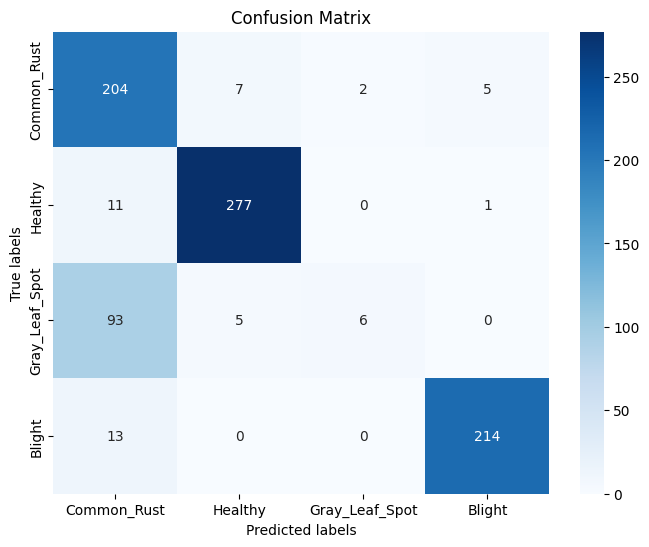


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.94      0.76       218
           1       0.96      0.96      0.96       289
           2       0.75      0.06      0.11       104
           3       0.97      0.94      0.96       227

    accuracy                           0.84       838
   macro avg       0.83      0.72      0.70       838
weighted avg       0.85      0.84      0.80       838



In [24]:
# Menggunakan model_resnet50ver2 untuk membuat prediksi pada data uji
Y_pred = model_resnet50ver2.predict(X_test)
# Mengambil indeks kelas dengan probabilitas tertinggi sebagai prediksi
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Mengambil indeks kelas dengan probabilitas tertinggi sebagai label sebenarnya
Y_true = np.argmax(Y_test, axis=1)

# Membuat confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Menampilkan confusion matrix dalam bentuk visualisasi
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'], yticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Membuat classification report
class_report = classification_report(Y_true, Y_pred_classes)

# Menampilkan classification report
print("\nClassification Report:")
print(class_report)

In [17]:
model_resnet50ver2.save('resnet50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
